In [1]:
#import main libraries (numpy for data and matplotlib for plotting)
import numpy as np 
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

c:\Users\KimGiHu\KAERI-intership\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

#User parameters
features=['A+IGBT-I', 'A+*IGBT-I', 'B+IGBT-I', 'B+*IGBT-I', 'C+IGBT-I', 'C+*IGBT-I', 'A-FLUX', 
          'B-FLUX', 'C-FLUX', 'MOD-V', 'MOD-I', 'CB-I', 'CB-V', 'DV/DT']  # waveform names to use as a header
feature_index=6  # A-flux waveform (for plotting). Use 0 for A+IGBT-I, 1 for A+*IGBT-I, and so on.
system='RFQ'     # pick a system to load and plot. Choose RFQ, DTL, CCL, or SCL

In [3]:
#load both waveform (X) and labels (Y) datasets for an HVCM module, e.g. RFQ, DTL, CCL, SCL
X= np.load('./hvcm/hvcm/%s.npy'%system)   #---> X array has shape: (pulses, times, features)
Y=np.load('./hvcm/hvcm/%s_labels.npy'%system, allow_pickle=True)  #---> Y array has shape: (pulses, labels) --> labels are: index, state, type
time=np.arange(X.shape[1]) * 400e-9    #create time axis based on the sampling rate 400 ns (for plotting purposes)

In [4]:
# Split X/Y arrays into fault and normal data

#obtain array indices to split normal and fault data using the second column in Y """
fault_indices, normal_indices=np.where(Y[:,1] == 'Fault')[0], np.where(Y[:,1] == 'Run')[0]

In [5]:
#Use the indices to assign normal data to `Xnormal` and fault data to `Xanomaly` 
Xnormal, Xanomaly = X[normal_indices,:,:], X[fault_indices,:,:]

In [6]:
# define the device
device = torch.device("cuda", index=0)

In [7]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [8]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)

        return output, self.hidden

In [9]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [10]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [33]:
iw = 24*7*2
ow = 24*7


train_dataset = windowDataset(Xanomaly[0,:,feature_index], input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

In [34]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [53]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

In [54]:
learning_rate=0.01
epoch = 3000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

## 학습하기 이전

In [55]:
predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

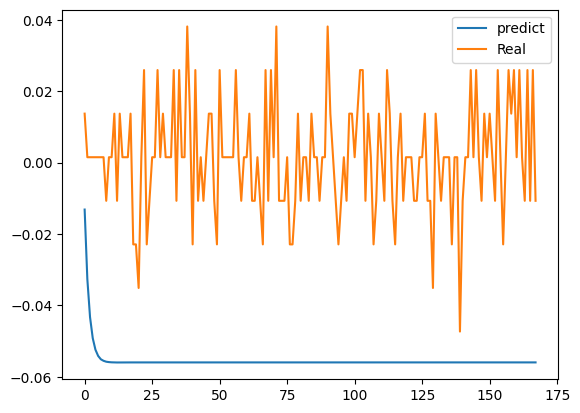

In [56]:
plt.plot(predict)
plt.plot(real)
plt.legend(["predict","Real"])

## 학습된 이후

In [17]:
from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

100%|██████████| 3000/3000 [7:44:43<00:00,  9.29s/it, loss=0.00039]  


In [18]:
torch.save(model, './lstm_3000_lr_01.h5')

In [58]:
model = torch.load ('./lstm_3000_lr_01.h5')
model.eval()

lstm_encoder_decoder(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 16, batch_first=True)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 16, batch_first=True)
    (linear): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [59]:
predict = model.predict(torch.tensor(Xanomaly[0,400:736,feature_index]).reshape(-1,1).to(device).float(), target_len=ow)
real = Xanomaly[0,400:736,feature_index]

In [46]:
real.shape

(336,)

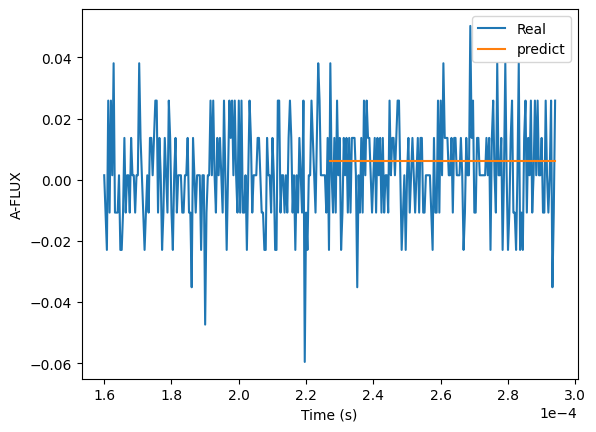

In [60]:
plt.figure()
#loop over all faulty pulses and plot the waveform given by feature_index
plt.plot(time[400:736], real)
plt.plot(time[568:736],predict)
plt.xlabel('Time (s)')  #add x-label
plt.legend(["Real","predict"])
plt.ylabel(features[feature_index]) #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot